In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle

import cell_order_log_analysis
import sys
sys.path.append('../radio_api')
import constants

In [2]:
FIG_SIZE = (8,5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

RESERVATION = 'RES130664'
reservation_data_dir = '../data/' + RESERVATION + '/'
cell_order_log_filename = reservation_data_dir + 'cell-order-changingBudgets-thp.log'
cell_order_ue_log_filename = reservation_data_dir + 'cell-order-ue3.log'

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period
N_PRB_PER_RBG = 3

In [3]:
bs_data, budgets, ts_start = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_data, SLA_PERIOD, OUTLIER_PERCENTILE)

cur_data, slice_id, _ = cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_log_filename, ts_start)
cur_data['supply_times'] -= ts_start
ue_data = {slice_id: cur_data}

active_slice = list(ue_data.keys())[0]
assert active_slice in bs_data.keys()

Data for 322.51200008392334 seconds has been extracted
UE Data for 318.0510001182556 seconds has been extracted


In [4]:
for user_id, supply_times in budgets['supply_times'].items():
    port_offset = int(user_id[0].split('.')[-1])
    sid = port_offset % constants.SLICE_NUM
    
    bs_data[sid]['filtered_ts_sec'] = []
    bs_data[sid]['filtered_tx_mbps'] = []
    bs_data[sid]['ave_ts_sec'] = []
    bs_data[sid]['ave_tx_mbps'] = []
    for supply_time in supply_times:
        supply_time -= ts_start
        ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                   bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue
        sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
        sla_tx_mbps = bs_data[sid]['raw_tx_mbps'][ts_filter]

        outlier_filter = np.logical_and(sla_tx_mbps <= np.percentile(sla_tx_mbps, 100 - OUTLIER_PERCENTILE),
                                        sla_tx_mbps >= np.percentile(sla_tx_mbps, OUTLIER_PERCENTILE))
        if (outlier_filter.any()):
            bs_data[sid]['filtered_ts_sec'] = \
                np.concatenate((bs_data[sid]['filtered_ts_sec'], sla_ts_sec[outlier_filter]))
            bs_data[sid]['filtered_tx_mbps'] = \
                np.concatenate((bs_data[sid]['filtered_tx_mbps'], sla_tx_mbps[outlier_filter]))
            bs_data[sid]['ave_ts_sec'].append(np.max(sla_ts_sec[outlier_filter]))
            bs_data[sid]['ave_tx_mbps'].append(np.mean(sla_tx_mbps[outlier_filter]))
        else:
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))
            bs_data[sid]['filtered_tx_mbps'].append(np.median(sla_tx_mbps))
            bs_data[sid]['ave_ts_sec'].append(np.max(sla_ts_sec))
            bs_data[sid]['ave_tx_mbps'].append(np.mean(sla_tx_mbps))
    bs_data[sid]['filtered_ts_sec'] = np.array(bs_data[sid]['filtered_ts_sec'])
    bs_data[sid]['filtered_tx_mbps'] = np.array(bs_data[sid]['filtered_tx_mbps'])
    bs_data[sid]['ave_ts_sec'] = np.array(bs_data[sid]['ave_ts_sec'])
    bs_data[sid]['ave_tx_mbps'] = np.array(bs_data[sid]['ave_tx_mbps'])

In [5]:
ue_data[active_slice]['filtered_ts_sec'] = []
ue_data[active_slice]['filtered_mbps'] = []
ue_data[active_slice]['ave_ts_sec'] = []
ue_data[active_slice]['ave_mbps'] = []
for supply_time in ue_data[active_slice]['supply_times']:
    ts_filter = np.logical_and(ue_data[active_slice]['raw_ts_sec'] >= supply_time,
                               ue_data[active_slice]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
    if (not ts_filter.any()):
        continue
    sla_ts_sec = ue_data[active_slice]['raw_ts_sec'][ts_filter]
    sla_tx_mbps = ue_data[active_slice]['raw_mbps'][ts_filter]

    outlier_filter = np.logical_and(sla_tx_mbps <= np.percentile(sla_tx_mbps, 100 - OUTLIER_PERCENTILE),
                                    sla_tx_mbps >= np.percentile(sla_tx_mbps, OUTLIER_PERCENTILE))
    if (outlier_filter.any()):
        ue_data[active_slice]['filtered_ts_sec'] = \
            np.concatenate((ue_data[active_slice]['filtered_ts_sec'], sla_ts_sec[outlier_filter]))
        ue_data[active_slice]['filtered_mbps'] = \
            np.concatenate((ue_data[active_slice]['filtered_mbps'], sla_tx_mbps[outlier_filter]))
        ue_data[active_slice]['ave_ts_sec'].append(np.max(sla_ts_sec[outlier_filter]))
        ue_data[active_slice]['ave_mbps'].append(np.mean(sla_tx_mbps[outlier_filter]))
    else:
        ue_data[active_slice]['filtered_ts_sec'].append(np.max(sla_ts_sec))
        ue_data[active_slice]['filtered_mbps'].append(np.median(sla_tx_mbps))
        ue_data[active_slice]['ave_ts_sec'].append(np.max(sla_ts_sec))
        ue_data[active_slice]['ave_mbps'].append(np.mean(sla_tx_mbps))
ue_data[active_slice]['filtered_ts_sec'] = np.array(ue_data[active_slice]['filtered_ts_sec'])
ue_data[active_slice]['filtered_mbps'] = np.array(ue_data[active_slice]['filtered_mbps'])
ue_data[active_slice]['ave_ts_sec'] = np.array(ue_data[active_slice]['ave_ts_sec'])
ue_data[active_slice]['ave_mbps'] = np.array(ue_data[active_slice]['ave_mbps'])

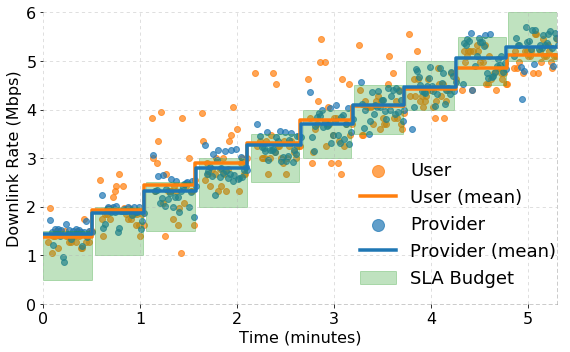

In [6]:
plt.figure(figsize = FIG_SIZE)

plt.scatter(ue_data[active_slice]['filtered_ts_sec'] / 60, 
         ue_data[active_slice]['filtered_mbps'], 
         label='User', color='C1', alpha=0.7)
plt.scatter(bs_data[active_slice]['filtered_ts_sec'] / 60, 
         bs_data[active_slice]['filtered_tx_mbps'], 
         label='Provider', color='C0', alpha=0.7)

plt.step(np.insert(ue_data[active_slice]['ave_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['ave_mbps'], 0, ue_data[active_slice]['ave_mbps'][0]), 
         where='pre', label='User (mean)', linewidth=3.5, color='C1')
plt.step(np.insert(bs_data[active_slice]['ave_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['ave_tx_mbps'], 0, bs_data[active_slice]['ave_tx_mbps'][0]), 
         where='pre', label='Provider (mean)', linewidth=3.5, color='C0')

cnt = 1
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - ts_start) / 60
    if (cnt == 1):
        plt.gca().add_patch(Rectangle((ts_minutes, cnt * 0.5), SLA_PERIOD / 60, 1, color='C2', alpha=0.3, label='SLA Budget'))
    else:
        plt.gca().add_patch(Rectangle((ts_minutes, cnt * 0.5), SLA_PERIOD / 60, 1, color='C2', alpha=0.3))
    cnt += 1

plt.gca().set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
plt.gca().set_ylabel('Downlink Rate (Mbps)', fontsize=FONT_SIZE)
plt.gca().tick_params(axis='y', labelsize=FONT_SIZE)
plt.gca().tick_params(axis='x', labelsize=FONT_SIZE)
plt.gca().set_ylim((0, 6))
plt.gca().yaxis.set_ticks(np.arange(0, 7))
plt.gca().set_xlim([0,5.3])
plt.gca().xaxis.set_ticks(np.arange(0, 6))

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 4, 1, 2] #specify order of items in legend
leg = plt.gca().legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       loc='lower right', frameon=False, fontsize=FONT_SIZE+2, markerscale=2,
                       bbox_to_anchor=[1.03, 0.0])

plt.gca().grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()  

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_thp.pdf')

plt.show()

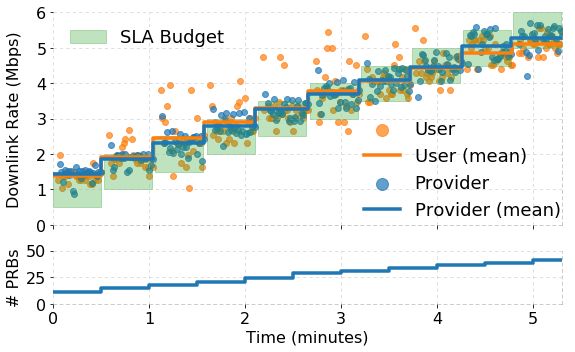

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=FIG_SIZE)

ax1.scatter(ue_data[active_slice]['filtered_ts_sec'] / 60, 
         ue_data[active_slice]['filtered_mbps'], 
         label='User', color='C1', alpha=0.7)
ax1.scatter(bs_data[active_slice]['filtered_ts_sec'] / 60, 
         bs_data[active_slice]['filtered_tx_mbps'], 
         label='Provider', color='C0', alpha=0.7)

ax1.step(np.insert(ue_data[active_slice]['ave_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['ave_mbps'], 0, ue_data[active_slice]['ave_mbps'][0]), 
         where='pre', label='User (mean)', linewidth=3.5, color='C1')
ax1.step(np.insert(bs_data[active_slice]['ave_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['ave_tx_mbps'], 0, bs_data[active_slice]['ave_tx_mbps'][0]), 
         where='pre', label='Provider (mean)', linewidth=3.5, color='C0')

cnt = 1
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - ts_start) / 60
    if (cnt == 1):
        ax1.add_patch(Rectangle((ts_minutes, cnt * 0.5), SLA_PERIOD / 60, 1, color='C2', alpha=0.3, label='SLA Budget'))
    else:
        ax1.add_patch(Rectangle((ts_minutes, cnt * 0.5), SLA_PERIOD / 60, 1, color='C2', alpha=0.3))
    cnt += 1

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Downlink Rate (Mbps)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 6))
ax1.yaxis.set_ticks(np.arange(0, 7))
ax1.set_xlim([0,5.3])
ax1.xaxis.set_ticks(np.arange(0, 6))

handles, labels = ax1.get_legend_handles_labels()
order = [3, 0, 4, 1] #specify order of items in legend
leg = ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc='lower right', frameon=False, fontsize=FONT_SIZE+2, markerscale=2,
                 bbox_to_anchor=[1.03, -0.05])
ax1.legend([handles[2]],[labels[2]],
           loc='upper left', frameon=False, fontsize=FONT_SIZE+2, markerscale=2)
ax1.add_artist(leg)

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax2.step(np.insert(bs_data[active_slice]['ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['n_rbgs'] * N_PRB_PER_RBG, 
                   0, bs_data[active_slice]['n_rbgs'][0] * N_PRB_PER_RBG), 
         label='Ave. PRB = {:.2f}'.format(np.mean(bs_data[active_slice]['raw_n_rbgs'] * N_PRB_PER_RBG)), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('# PRBs', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.set_ylim((0, 50))
ax2.yaxis.set_ticks(np.arange(0,51,25))
ax2.set_xlim([0,5.3])
ax2.xaxis.set_ticks(np.arange(0, 6))

# ax2.legend(loc='lower left', frameon=False, fontsize=FONT_SIZE+2,
#            bbox_to_anchor=[-0.01,0.0])

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()


if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_thp_and_prb.pdf')

plt.show()

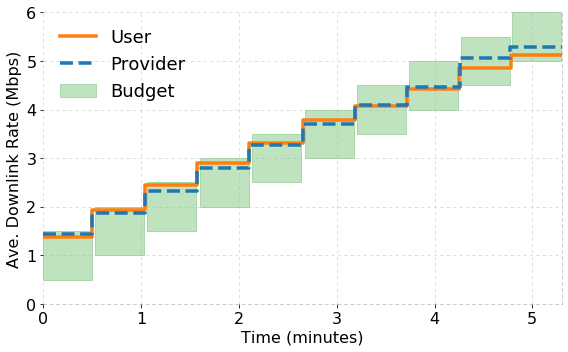

In [8]:
plt.figure(figsize = FIG_SIZE)

plt.step(np.insert(ue_data[active_slice]['ave_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['ave_mbps'], 0, ue_data[active_slice]['ave_mbps'][0]), 
         where='pre', label='User', linewidth=3.5, color='C1')
plt.step(np.insert(bs_data[active_slice]['ave_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['ave_tx_mbps'], 0, bs_data[active_slice]['ave_tx_mbps'][0]), 
         where='pre', label='Provider', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - ts_start) / 60
    if (cnt == 1):
        plt.gca().add_patch(Rectangle((ts_minutes, cnt * 0.5), SLA_PERIOD / 60, 1, color='C2', alpha=0.3, label='Budget'))
    else:
        plt.gca().add_patch(Rectangle((ts_minutes, cnt * 0.5), SLA_PERIOD / 60, 1, color='C2', alpha=0.3))
    cnt += 1

plt.gca().set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
plt.gca().set_ylabel('Ave. Downlink Rate (Mbps)', fontsize=FONT_SIZE)
plt.gca().tick_params(axis='y', labelsize=FONT_SIZE)
plt.gca().tick_params(axis='x', labelsize=FONT_SIZE)
plt.gca().set_ylim((0, 6))
plt.gca().yaxis.set_ticks(np.arange(0, 7))
plt.gca().set_xlim([0,5.3])
plt.gca().xaxis.set_ticks(np.arange(0, 6))

plt.gca().legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2)

plt.gca().grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout() 

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_ave_thp.pdf')

plt.show()

In [9]:
thp_diff = ue_data[active_slice]['ave_mbps'] - bs_data[active_slice]['ave_tx_mbps']
print('The measurement difference:\n{}'.format(thp_diff))

thp_diff_wrt_ue = np.divide(thp_diff, ue_data[active_slice]['ave_mbps']) * 100
print('The measurement difference wrt UE (%):\n{}'.format(thp_diff_wrt_ue))

thp_diff_wrt_bs = np.divide(thp_diff, bs_data[active_slice]['ave_tx_mbps']) * 100
print('The measurement difference wrt UE (%):\n{}'.format(thp_diff_wrt_bs))

The measurement difference:
[-0.04737372  0.05694704  0.12872961  0.11434416  0.0412252   0.08936914
 -0.00949352 -0.04451036 -0.20421898 -0.17540785]
The measurement difference wrt UE (%):
[-3.41891832  2.95861152  5.25301334  3.9302037   1.2478857   2.35706997
 -0.23287236 -1.00626734 -4.20131251 -3.42943147]
The measurement difference wrt UE (%):
[-3.30589255  3.04881408  5.54425373  4.09098786  1.26365467  2.4139689
 -0.23233133 -0.99624248 -4.031919   -3.31572109]
